In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('C:\\Users\\saleh\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages')

import os
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance
from math import ceil

import seaborn as sns
import matplotlib.dates as mdates

In [2]:
# Define the folder path
folder_path = 'C:\\Users\\saleh\\Documents\\kaggle_sales_forecast\\data'

# Initialize a list to store dataframes
dataframes = []

# Optionally, if you want to store dataframes in a dictionary with filenames as keys
dataframes_dict = {os.path.splitext(filename)[0]: pd.read_csv(os.path.join(folder_path, filename)) for filename in os.listdir(folder_path) if filename.endswith(('.csv', '.xls'))}


In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train = dataframes_dict['train']
transactions = dataframes_dict['transactions']
stores = dataframes_dict['stores']
holidays_events = dataframes_dict['holidays_events']
oil = dataframes_dict['oil']

In [4]:
train['date'] = pd.to_datetime(train['date'])

In [5]:
def create_date_features(df):
    
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['dow'] = df['date'].dt.dayofweek
    

    def week_of_month(dt):
        """ Returns the week of the month for the specified date.
        """

        first_day = dt.replace(day=1)

        dom = dt.day
        adjusted_dom = dom + first_day.weekday()

        return int(ceil(adjusted_dom/7.0))
    
    df['weekofmonth'] = df['date'].apply(week_of_month)
    
    return df

In [6]:
train = pd.merge(left=train, right=stores, how='left', on='store_nbr')
#train

In [7]:
test = dataframes_dict['test']
test['date'] = pd.to_datetime(test['date'])
test = pd.merge(left=test, right=stores, how='left', on='store_nbr')
#test

In [8]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events = holidays_events.rename(columns={
    'type': 'holiday_type',
    'description': 'holiday_description'
})
national_holidays = holidays_events[holidays_events.locale == 'National']
regional_holidays = holidays_events[holidays_events.locale == 'Regional']
local_holidays = holidays_events[holidays_events.locale == 'Local']
#local_holidays

In [9]:
train = pd.merge(left=train, right=national_holidays, how='left', on='date')
test = pd.merge(left=test, right=national_holidays, how='left', on='date')

In [10]:
# Merge df1 and df2 based on 'col1' and 'col2'
merged_train = pd.merge(train, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_update'))

# Update df1 with the values from df2 wherever df2 is joined
for col in regional_holidays.columns:
    if col not in ['date', 'locale_name']:  # Exclude the join columns
        merged_train[col] = merged_train[col + '_update'].combine_first(merged_train[col])

# Drop the extra columns used for updating
merged_train = merged_train[train.columns]

merged_test = pd.merge(test, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left', suffixes=('', '_update'))

# Update df1 with the values from df2 wherever df2 is joined
for col in regional_holidays.columns:
    if col not in ['date', 'locale_name']:  # Exclude the join columns
        merged_test[col] = merged_test[col + '_update'].combine_first(merged_test[col])

# Drop the extra columns used for updating
merged_test = merged_test[test.columns]
#merged_test

In [11]:
merged_train = merged_train.drop('locale_name', axis=1)
merged_test = merged_test.drop('locale_name', axis=1)

In [12]:
merged_test.columns[merged_test.isna().any()]

Index(['holiday_type', 'locale', 'holiday_description', 'transferred'], dtype='object')

In [13]:
merged_train.fillna('NA', inplace=True)
merged_test.fillna('NA', inplace=True)

In [14]:

merged_train['cluster'] = merged_train['cluster'].astype(object)
merged_test['cluster'] = merged_test['cluster'].astype(object)


In [15]:
def create_lag_features(df, group_cols, target_col, lags=[1, 7, 30]):
    """
    Create lag features and rolling statistics for the target column within each group.

    Parameters:
    - df: pandas DataFrame containing the data
    - group_cols: list of column names representing the groups (e.g., ['store', 'family'])
    - target_col: column name representing the target variable (e.g., 'sales')
    - lags: list of integers representing lag periods (e.g., [1, 7, 30])

    Returns:
    - df: pandas DataFrame with the newly created lag and rolling features
    """
    # Ensure the data is sorted by the group columns and date
    df = df.sort_values(by=group_cols + ['date'])
    
    # Create lag features
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)

    return df


In [16]:
# Add the 'sales' column to the test set with placeholder values (e.g., 0)
merged_test['sales'] = 0
merged_test['set'] = 'test'
merged_train['set'] = 'train'

# Concatenate the train and test sets
combined_df = pd.concat([merged_train, merged_test],ignore_index=True)

# Step 2: Create Lag Features on the Combined Dataset
combined_df = create_lag_features(combined_df, group_cols=['family','store_nbr'], target_col='sales', lags = [30,60,180,365])

merged_train_with_lags = combined_df[combined_df.set=='train']
merged_test_with_lags = combined_df[combined_df.set=='test']

In [17]:
merged_test_with_lags = merged_test_with_lags.drop(columns=['sales','set'])
merged_train_with_lags = merged_train_with_lags.drop(columns=['set'])

In [18]:
#merged_train_with_lags.tail()
daily_sales = merged_train_with_lags.groupby(['store_nbr', 'date'])['sales'].sum().reset_index()
#daily_sales.tail()

In [19]:
# Checking how many zero sales days does each store have
zero_sales_days = daily_sales[daily_sales['sales'] == 0]

zero_sales_count = zero_sales_days.groupby('store_nbr').size().reset_index(name='zero_sales_days')
#zero_sales_count

In [20]:
# Removing data for stores for days where total sales are zero for the day.

non_zero_sales_days = daily_sales[daily_sales['sales'] > 0]

train_filtered = pd.merge(merged_train_with_lags, non_zero_sales_days[['store_nbr', 'date']], on=['store_nbr', 'date'])




In [21]:
# daily_sales_total = train_filtered.groupby(['date'])['sales'].sum().reset_index()

# for year in daily_sales_total.date.dt.year.unique():
#     plt.figure(figsize=(18,9))
#     sns.lineplot(x='date', y='sales', data=daily_sales_total[daily_sales_total.date.dt.year == year])
    
#     holidays_df = national_holidays[(national_holidays.holiday_type.isin(['Holiday','Transfer'])) & (national_holidays.transferred != True) & (national_holidays.date.dt.year == year)]['date']
#     for holiday in holidays_df:
#         plt.axvline(x=holiday, color='red', linestyle='--', linewidth=1)
    
#     # Customize the plot
#     plt.title(f'Total Daily Sales {year}')
#     plt.xlabel('Date')
#     plt.ylabel('Total Sales')
#     plt.xticks(rotation=45)
#     plt.grid(True)
    
#     # Show the plot for each store
#     plt.show()

# # No national holidays have any impact on sales in August.


In [22]:
# daily_sales_state = train_filtered.groupby(['state','date'])['sales'].mean().reset_index()

# for state in daily_sales_state['state'].unique():
#     daily_sales_total = daily_sales_state[daily_sales_state['state'] == state]
#     plt.figure(figsize=(18,9))
#     sns.lineplot(x='date', y='sales', data=daily_sales_total)
    
#     holidays_df = regional_holidays[(regional_holidays.locale_name == state)]['date']
#     #print(holidays_df)
#     for holiday in holidays_df:
#         plt.axvline(x=holiday, color='red', linestyle='--', linewidth=1)

#     holidays_df = national_holidays[(national_holidays.holiday_type.isin(['Holiday','Transfer'])) & (national_holidays.transferred != True)]['date']
#     for holiday in holidays_df:
#         plt.axvline(x=holiday, color='green', linestyle='--', linewidth=1)
#     # Customize the plot
#     plt.title(f'Total Daily Sales for {state} in {year}')
#     plt.xlabel('Date')
#     plt.ylabel('Total Sales')
#     plt.xticks(rotation=45)
#     plt.grid(True)
    
#     # Show the plot for each store
#     plt.show()
    
#     # No Regional holidays have any impact on sales in August.


In [23]:
# daily_sales_city = train_filtered.groupby(['city','date'])['sales'].mean().reset_index()

# for city in local_holidays['locale_name'].unique():
#     daily_sales_total = daily_sales_city[daily_sales_city['city'] == city]
#     plt.figure(figsize=(18,9))
#     sns.lineplot(x='date', y='sales', data=daily_sales_total)
    
#     holidays_df = local_holidays[(local_holidays.locale_name == city)]['date']
#     #print(holidays_df)
#     for holiday in holidays_df:
#         plt.axvline(x=holiday, color='orange', linestyle='--', linewidth=1)

#     # holidays_df = national_holidays[(national_holidays.holiday_type.isin(['Holiday','Transfer'])) & (national_holidays.transferred != True)]['date']
#     # for holiday in holidays_df:
#     #     plt.axvline(x=holiday, color='green', linestyle='--', linewidth=1)
#     # Customize the plot
#     plt.title(f'Total Daily Sales for {city}')
#     plt.xlabel('Date')
#     plt.ylabel('Total Sales')
#     plt.xticks(rotation=45)
#     plt.grid(True)
    
#     # Show the plot for each store
#     plt.show()
    
#     # No national holidays have any impact on sales in August.


In [24]:
# Cluster analysis
store_count_per_cluster = train_filtered.groupby('cluster')['store_nbr'].nunique().reset_index(name='store_count')

average_sales_per_cluster = train_filtered.groupby('cluster')['sales'].mean().reset_index(name='average_sales')

cluster_summary = pd.merge(store_count_per_cluster, average_sales_per_cluster, on='cluster')

#cluster_summary


In [25]:
train_filtered['city_new'] = np.where(train_filtered['city'] == 'Quito', 'Quito', 'Other')
merged_test_with_lags['city_new'] = np.where(merged_test_with_lags['city'] == 'Quito', 'Quito', 'Other')
merged_test_with_lags.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,holiday_type,locale,holiday_description,transferred,sales_lag_30,sales_lag_60,sales_lag_180,sales_lag_365,city_new
3008016,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,2.00,3.00,7.00,4.00,Quito
3009798,3002670,2017-08-17,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,3.00,2.00,3.00,5.00,Quito
3011580,3004452,2017-08-18,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,7.00,3.00,0.00,4.00,Quito
3013362,3006234,2017-08-19,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,4.00,3.00,2.00,6.00,Quito
3015144,3008016,2017-08-20,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NA,NA,NA,NA,10.00,1.00,2.00,12.00,Quito


In [26]:
def one_hot_encoding(train,test,cat_features):
    ohe = OneHotEncoder()
    
    ohe_train = ohe.fit_transform(train[cat_features]).toarray()
    ohe_train = pd.DataFrame(ohe_train,columns=ohe.get_feature_names_out())
    train.drop(cat_features,axis=1,inplace=True)
    train.reset_index(drop=True,inplace=True)
    train = pd.concat([train,ohe_train],axis=1)
    
    ohe_test = ohe.transform(test[cat_features]).toarray()
    ohe_test = pd.DataFrame(ohe_test,columns=ohe.get_feature_names_out())
    test.drop(cat_features,axis=1,inplace=True)
    test.reset_index(drop=True,inplace=True)
    test = pd.concat([test,ohe_test],axis=1)
    
    return (train,test)

In [27]:

train_filtered = train_filtered.drop(columns=['holiday_description','state','city','holiday_type'])
merged_test_with_lags = merged_test_with_lags.drop(columns=['holiday_description','state','city','holiday_type'])
cat_features = train_filtered.columns[train_filtered.dtypes=='object']

In [28]:
train_filtered[cat_features] = train_filtered[cat_features].astype(str)
merged_test_with_lags[cat_features] = merged_test_with_lags[cat_features].astype(str)

In [29]:
train_filtered = create_date_features(train_filtered)
merged_test_with_lags = create_date_features(merged_test_with_lags)

In [30]:
dow_avg = train_filtered[train_filtered.date.dt.year >= 2016].groupby(['dow','store_nbr','family'])['sales'].mean().reset_index()

dow_avg = dow_avg.rename(columns={
    'sales': 'dow_avg'
})

train_filtered = pd.merge(train_filtered, dow_avg, on=['dow', 'store_nbr', 'family'])
merged_test_with_lags = pd.merge(merged_test_with_lags, dow_avg, on=['dow', 'store_nbr', 'family'])

In [31]:
#merged_test_with_lags.tail()

In [32]:
train_data,test_data = one_hot_encoding(train_filtered,merged_test_with_lags,cat_features)

In [33]:
from sklearn.model_selection import train_test_split

# Custom metric function

def custom_metric(estimator,X,y):
    y_pred = estimator.predict(X)
    y_true = np.array(y)
    y_pred = np.array(y_pred)
    y_pred = np.maximum(y_pred, 0)
    log_diff = np.log(1 + y_pred) - np.log(1 + y_true)
    squared_diff = np.square(log_diff)
    mean_squared_diff = np.mean(squared_diff)
    
    return np.sqrt(mean_squared_diff)

In [34]:
train_data.columns[train_data.isna().any()]

Index(['sales_lag_30', 'sales_lag_60', 'sales_lag_180', 'sales_lag_365'], dtype='object')

In [35]:
train_data.fillna(0, inplace=True)

In [36]:
# Ensure data is sorted by date
train_data = train_data.sort_values(by='id')
train_data = train_data.drop(columns=['date','id'])

# Define features and target
X = train_data.drop(columns=['sales'])
y = train_data['sales']

# Train-test split based on temporal order
split_index = int(len(train_data) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [37]:
# Sample the last 50% of the data
sample_size = int(len(X_train) * 0.4)

X_train_sample = X_train[-sample_size:]
y_train_sample = y_train[-sample_size:]


In [38]:
from sklearn.ensemble import RandomForestRegressor

custom_scorer = make_scorer(custom_metric, greater_is_better=False)

# Random Forest model
rf_model = RandomForestRegressor(random_state=28, n_jobs=-1)

# Define the parameter grid
param_grid = {
    'n_estimators': [200],
    'max_depth': [9],
    'min_samples_split': [5]
}


# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring=custom_scorer,
                           cv=TimeSeriesSplit(n_splits=3),
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search
grid_search.fit(X_train_sample, y_train_sample)

# Print the best results
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
print(best_parameters)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saleh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


Best score: nan
Best parameters set:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': -1, 'oob_score': False, 'random_state': 28, 'verbose': 0, 'warm_start': False}


In [39]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,559.51,170.01,3.12,1.75,9,5,200,"{'max_depth': 9, 'min_samples_split': 5, 'n_es...",NaN,NaN,NaN,NaN,NaN,1


In [117]:
# best_index = np.argmax(grid_search.cv_results_['rank_test_score'])

# # Get the best model based on the lowest score
# best_model = grid_search.cv_results_['params'][best_index]

# # You can also directly refit the model with the best parameters
# best_model = XGBRegressor(**best_model)
# best_model.fit(X_train, y_train)


In [40]:
custom_metric(grid_search.best_estimator_,X_test,y_test)

0.47479098374469575

In [41]:
train_preds = grid_search.best_estimator_.predict(X)
train_preds = np.maximum(train_preds, 0)

In [42]:
train_data['preds'] = (train_preds)
train_data['date'] = train_filtered['date']

In [43]:
#merged_train[merged_train.store_nbr==9].groupby(['family'])['sales'].sum()

<Axes: xlabel='date'>

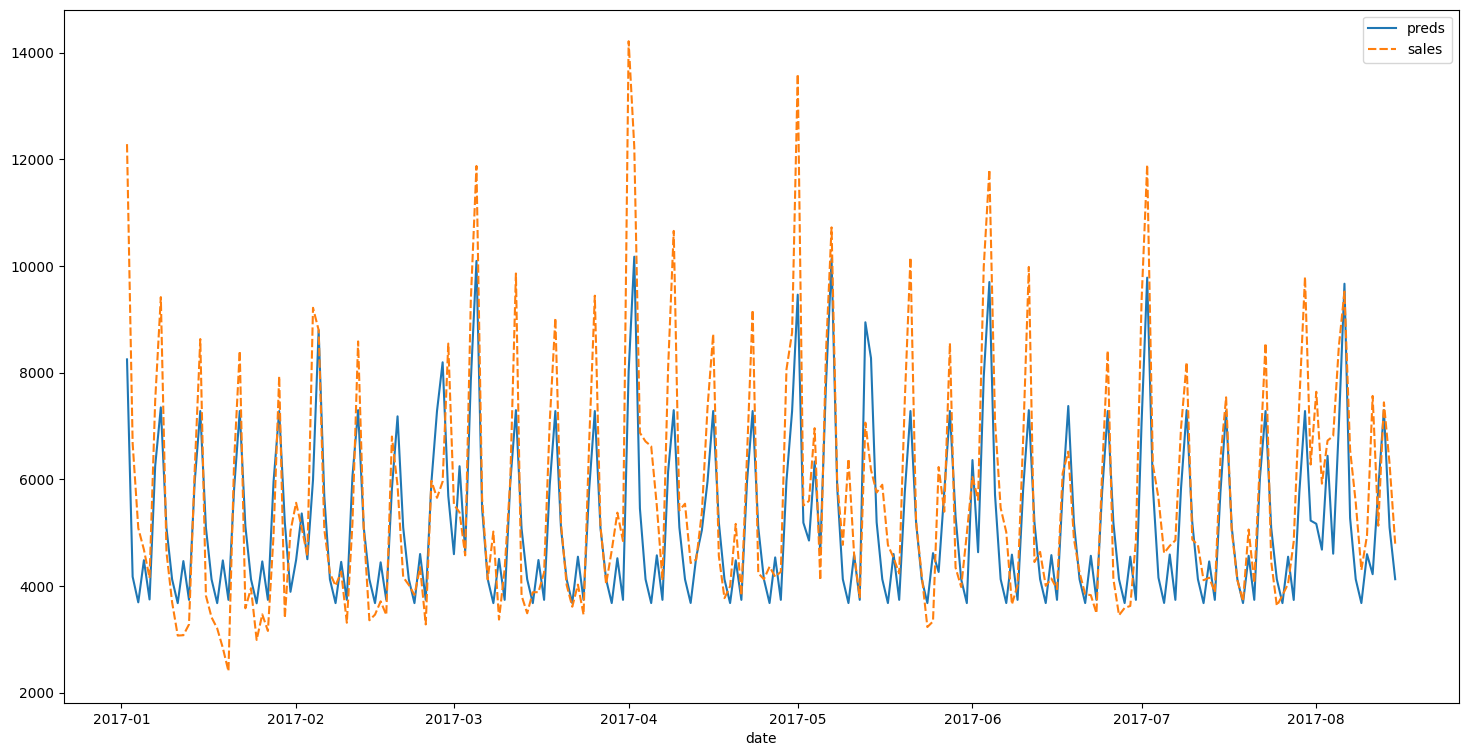

In [45]:
t_1_1 = train_data[(train_data.store_nbr==20) & (train_data['family_GROCERY I']==1)  & (train_data['year']==2017)]
t_1_1.set_index('date',inplace=True)
fig = plt.figure(figsize=(18,9))
sns.lineplot(data=t_1_1[['preds','sales']])

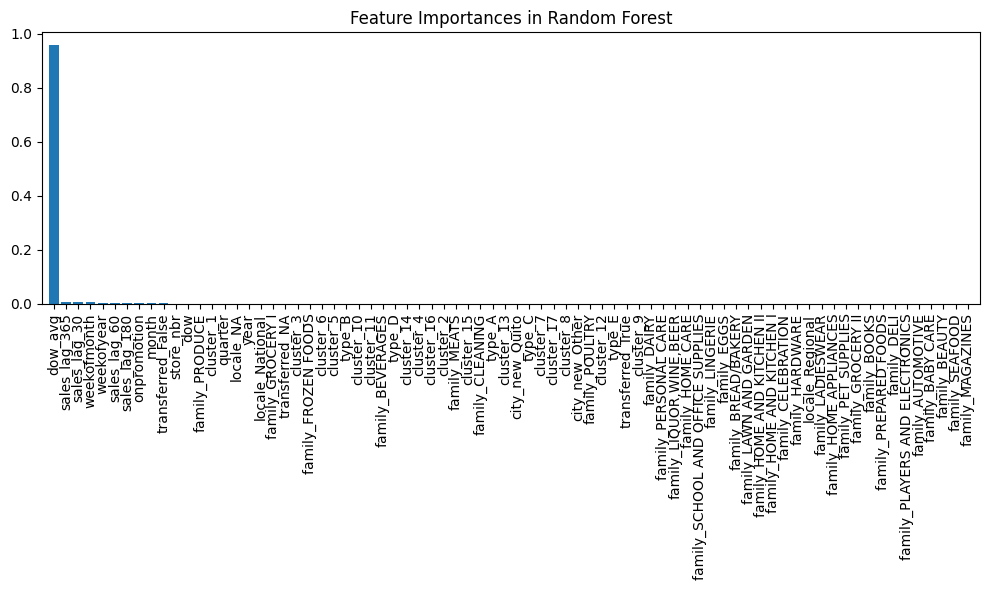

In [47]:
# Get the feature importances
importances = grid_search.best_estimator_.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the names of the features sorted by importance
feature_names = X_train.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [48]:
test_preds = grid_search.best_estimator_.predict(test_data.drop(columns=['date','id']))
test_preds = np.maximum(test_preds, 0)

In [49]:
test_data['sales'] = test_preds
test_data['id'] = merged_test_with_lags['id']

In [50]:
test_data[['id','sales']].to_csv('sub_4.csv', index=False)